# Implementing Vi(sual)T(transformer) in PyTorch

Hi guys, happy new year! Today we are going to implement the famous **Vi**(sual)**T**(transformer) proposed in [AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/pdf/2010.11929.pdf).


Code is here, an interactive version of this article can be downloaded from [here](https://github.com/FrancescoSaverioZuppichini/ViT).

ViT will be soon available on my **new computer vision library called [glasses](https://github.com/FrancescoSaverioZuppichini/glasses)**

This is a technical tutorial, not your normal medium post where you find out about the top 5 secret pandas functions to make you rich. 

So, before beginning, I highly recommend you to:

- have a look at the amazing [The Illustrated Transformer
](https://jalammar.github.io/illustrated-transformer/) website
- watch [Yannic Kilcher video about ViT](https://www.youtube.com/watch?v=TrdevFK_am4&t=1000s)
- read [Einops](https://github.com/arogozhnikov/einops/) doc

So, ViT uses a normal transformer (the one proposed in [Attention is All You Need](https://arxiv.org/abs/1706.03762)) that works on images. But, how?

The following picture shows ViT's architecture

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/ViT.png?raw=true)

The input image is decomposed into 16x16 flatten patches (the image is not in scale). Then they are embedded using a normal fully connected layer, a special `cls` token is added in front of them and the `positional encoding` is summed. The resulting tensor is passed first into a standard Transformer and then to a classification head. That's it. 

The article is structure into the following sections:

- Data
- Patches Embeddings
    - CLS Token
    - Position Embedding
- Transformer
    - Attention
    - Residuals
    - MLP
    - TransformerEncoder
- Head
- ViT

We are going to implement the model block by block with a bottom-up approach. We can start by importing all the required packages

### Einops Tutorial 필독!

https://github.com/arogozhnikov/einops/tree/master/docs

<Einops 기본 개념과 예시>
1. rearrange
    - 텐서의 차원을 형태 변환하는 작업을 직관적으로 표현함.
    
    1. 텐서의 차원을 변환함.
        
        ```python
        # 기존 방식: x.transpose(0, 2, 3, 1)
        # einops 방식:
        y = rearrange(x, 'b c h w -> b h w c')
        ```
        - **batch(b)**, **channel(c)**, **height(h)**, **width(w)** 순서의 텐서를,
        - **b, h, w, c** 순서로 차원을 변환함
        

    2. 차원 합성 및 분해함.
        
        ```python
        # 배치와 높이 축을 하나로 합성
        rearrange(ims, 'b h w c -> (b h) w c')
        ```
        
        - 여기서 batch와 h 축을 합쳐서 하나의 새로운 축을 만듬
        - 결과: 3D 


----------------------
2. 차원 축소(reduce)
    
    ```python
    # 특정 축에 대해 평균을 계산하는 NumPy의 mean(axis=0)과 같은 기능임!
    reduce(ims, 'b h w c -> h w c', 'mean')
    ```
    
    - 텐서의 특정 축에 대해 값들의 평균을 계산하고 그 축을 제거하여 새로운 텐서를 반환함.
    - 더 직관적으로 축소할 축 명시함
    - 예시: ims가 (6, 96, 96, 3)이고, mean(axis=0)를 적용하면 batch 차원을 제거하고, 나머지 차원(96x96x3) h, w, c에 대해 모든 이미지의 평균을 계산하고 그 결과를 반환함. 따라서 반환 shape: (96, 96, 3)

-----------------------
3. 텐서의 특정 축 반복 혹은 새로운 축을 추가해서 텐서 크기 늘림 (repeat)
    
    ```python
    repeat(ims[0], 'h w c -> h new_axis w c', new_axis=5)
    ```
    
    - 텐서의 특정 축을 반복하거나 새로운 축을 추가하여 텐서 크기를 늘릴 수 있음.
    - `ims[0]` ims의 첫 번째 이미지를 새로운 축인 `new_axis`로 추가해서, 5번 반복하여 크기가 `(96, 5, 96, 3)`인 텐서를 만듬. 5배로 늘림.

In [21]:
# einops install진행
# Flexible and powerful tensor operations for readable and reliable code.

In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
# pytorch 모델을 summary 해주는 Torch summary module이다. 없다면 설치.
# 네트워크의 구성, 파라미터의 개수, 
# 파라미터의 용량, 연산 수를 확인할 수 있다.

Nothing fancy here, just PyTorch + stuff

## Data

First of all, we need a picture, a cute cat works just fine :)

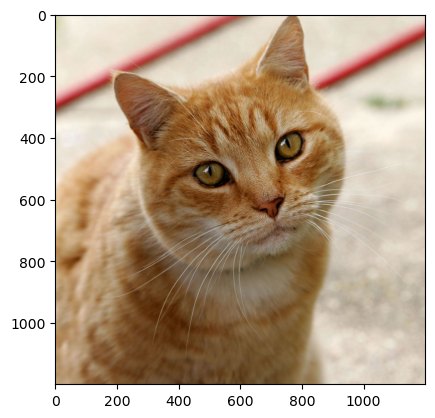

In [23]:
img = Image.open('./cat.jpg')

fig = plt.figure()
plt.imshow(img)

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/output_5_1.png?raw=true)

Then, we need to preprocess it

In [24]:
# resize to imagenet size 
transform = Compose([Resize((224, 224)), ToTensor()]) # PyTorch 텐서로 변환하기
# [Channel(RGB), Height, Weight]형식의 텐서 => 3,224,224

x = transform(img)
x = x.unsqueeze(0) # add batch dim 배치 차원 추가해서,
x.shape # torch.Size([1, 3, 224, 224]) 이렇게 나옴. 


torch.Size([1, 3, 224, 224])

- 224x224로 (imagenet size로) resize.

- ViT 모델은 ImageNet 데이터셋과 같은 표준이미지 크기인 224x224로 입력으로 받기 때문.

- 배치 차원 추가해서, torch.Size([1, 3, 224, 224]) 이렇게 나옴
    - 왜 추가? ViT도 [batch_size, channels, height, width] 형식으로 배치 단위로 입력 받음

- 이미지 한 장이라서 batch size는 1이다.

## Patches Embeddings

The first step is to break-down the image in multiple patches and flatten them.

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/Patches.png?raw=true)

Quoting from the paper:

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/paper1.png?raw=true)


This can be easily done using einops. 

- 여기서는 einops를 적극 활용한다.
- Einops를 사용해 224x224 크기의 이미지를 16x16 크기의 패치로 나누고, 그 패치들을 다시 1D 벡터로 변환함.

In [25]:
patch_size = 16 # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

- b: batch size =1 (이미지 한 장이기 때문.)

- c: channer =3 (RGB 이미지이기에)

- h: 224

- w: 224

- s1, s2: patch size, 16x16

<설명>
b c (h s1) (w s2) 부분:
- 이미지 텐서 x의 크기 변환: einops의 rearrange사용
    - (h s1): h 224를 16씩 나누어서 패치 단위로 변환,
    - (w s2): h 224를 16씩 나누어서 패치 단위로 변환.

그래서 16x16 패치로 총 196개의 패치로 나눠짐.

---------
b (h w) (s1 s2 c) 부분:

- (h w)는 패치 수(= 196개)를 나타냄.

- (s1 s2 c)는 각 패치(16x16)의 정보를 하나의 1D 벡터로 표현한 것임. 

- 즉, 이미지 텐서를 196개의 패치로 나누고, 각 패치를 1D 벡터로 변환한 다음, Transformer에 입력할 수 있는 형태로 만들어짐 16x16x3 = 768-d

Now, we need to project them using a normal linear layer

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/PatchesProjected.png?raw=true)

We can create a `PatchEmbedding` class to keep our code nice and clean

### PatchEmbedding class: 이미지 패치를 임베딩 벡터로 변환함

- init에서 입력 이미지의 channel(=3), patch_size(=16), emb_size(Transformer에 입력될 때 사용하는 임베딩 벡터의 차원=768)을 정의함.

In [26]:
class PatchEmbedding(nn.Module): 
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            # h를 16(s1)으로 나누고=14, w를 16(s2)으로 나눔=14.
            # 그리고 총14x14 = 196개(h w), 16x16x3= 768차원(s1 s2 c)의 벡터가 됨
            # 즉 flatten된 것.
            
            nn.Linear(patch_size * patch_size * in_channels, emb_size) 
            # flatten된 patch 벡터(768차원)을 emb_size로 다시 변환. 같은 차원 출력됨
            # 왜 emb_size=768 차원으로 다시 linear 변환하는가?
            # 차원은 그대로지만, 내부 값은 바뀜. 중요한 패턴과 문맥을 반영함!!
        )
                
    def forward(self, x: Tensor) -> Tensor: # 입력: [b, c, h, w]
        x = self.projection(x)
        return x # 출력: [b, 총 패치 수, emb_size]

PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

**Note** After checking out the original implementation, I found out that the authors are using a Conv2d layer instead of a Linear one for performance gain. This is obtained by using a kernel_size and stride equal to the `patch_size`.  Intuitively, the convolution operation is applied to each patch individually. So, we have to first apply the conv layer and then flat the resulting images.

- Linear Layer와 Conv2D Layer의 차이가 존재한다.
    - 원래 방식에선 nn.Linear로 이미지를 패치로 나눠서 각 패치를 1D 패치로 변환함.
        - 패치 하나하나에 대해 변환하는 연산을 하는 방식임        
       
    - 이때 Conv2D layer를 사용해 성능이 개선되었다고 한다.
        - kernel이라는 filter로 이미지를 처리.
        - kernel_size와 stride를 patch size와 동일하게 설정하면, 각 패치를 독립적으로 처리할 수 있다. (아래 코드 참고.)
        - 근데 왜 빠름? GPU의 병렬 연산에 매우 효율적이기 때문. Conv2D는 한번에 여러 패치에 대한 연산을 병렬로 수행할 수 있기 때문

In [27]:
# Conv2D 설정!
# kernel_size와 stride를 patch size와 동일하게 설정하였다!!

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x) # 출력 [b, 전체patch수, e]
        return x
    
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

- Conv2D layer의 출력은 [b, emb_size, (세로(h)로 나누어진)patch수, (가로(w)로 나누어진)patch수]의 형태이고,
    - (세로(h)로 나누어진)patch수, (가로(w)로 나누어진)patch수
        : 이 예제에서는 14, 14
- 이걸 1D로 변환. Rearrange('b e (h) (w) -> b (h w) e')
    - [b, 전체patch수, e]
        - 이 예제에서는 14x14=196개

### CLS Token

Next step is to add the `cls token` and the position embedding. The `cls token` is just a number placed in from of **each** sequence (of projected patches)

In [28]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size)) 
        # 이 예제에선 (1, 1, 768)
        
    def forward(self, x: Tensor) -> Tensor: 
        b, _, _, _ = x.shape
        x = self.projection(x) # 입력: [b, c, h, w], 출력: [b, 패치 총개수, e]
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # CLS Token: 원래 크기가 (1,1,768)인데, 
        # 이 토큰을 batch 크기 b만큼 복사하여, (b, 1, 768)로 확장.
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1) #그리고 이 토큰을 기존의 패치 임베딩 sequence의 맨 앞에 추가.
        # [b, 패치 총개수, e]에서 [b, 패치 총개수+1, e]로 됨.
        
        return x

    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

`cls_token` is a torch Parameter randomly initialized, in the forward the method it is copied `b` (batch) times and prepended before the projected patches using `torch.cat`

### Position Embedding

So far, the model has no idea about the original position of the patches. We need to pass this spatial information. This can be done in different ways, in ViT we let the model learn it. The position embedding is just a tensor of shape `N_PATCHES + 1 (token), EMBED_SIZE` that is added to the projected patches.

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/PatchesPositionEmbedding.png?raw=true)

- 이미지 패치의 위치 정보를 추가하자.


In [29]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size), # [1, 3, 224, 224] => [1, 768, 14, 14] 
            # [1, 3, 224, 224] -> [1, 768, 14, 14]
            
            Rearrange('b e (h) (w) -> b (h w) e'),
            # [1, 768, 14, 14] -> [1, 196, 768] 
        )
        
        # Classification Token 정의
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size)) # (1, 1, 768)
        
        # Position Embedding 패치 위치 정보 정의
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))
        # (197, 768) (196 + CLS토큰 1개)
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x) # [1,3,224,224]->[1, 196, 768]로.
        
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b) 
        # CLS Token을 배치 크기만큼 복사하기
        # [1, 1, emb_size] -> [batch, 1, emb_size]
        # 현재 예제에선 [1, 1, 768]
        
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1) # CLS Token을 패치 앞에 추가 
        # [1,196, 768]-> [1,197,768]
        
        # add position embedding
        x += self.positions # 위치정보를 단순히 더함(각 패치 및 CLS Token에.) 
        # -> [1, 197, 768]
        
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

We added the position embedding in the `.positions` field and sum it to the patches in the `.forward` function

## Transformer

Now we need the implement Transformer. In ViT only the Encoder is used, the architecture is visualized in the following picture.

<img src="https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/TransformerBlock.png?raw=true" alt="drawing" width="200"/>

Let's start with the Attention part

### Attention

So, the attention takes three inputs, the famous queries, keys, and values, and computes the attention matrix using queries and values and use it to "attend" to the values. In this case, we are using multi-head attention meaning that the computation is split across n heads with smaller input size.

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/TransformerBlockAttention.png?raw=true)

We can use `nn.MultiHadAttention` from PyTorch or implement our own. For completeness I will show how it looks like:

In [30]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        
        # linear projection
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        
        self.att_drop = nn.Dropout(dropout) # Dropout
        self.projection = nn.Linear(emb_size, emb_size) 
        # Multi-Head Attention 결과 합침
        # 여러 Head에서 계산된 Attention 출력을 다시 768차원의 벡터로 변환
        
        self.scaling = (self.emb_size // num_heads) ** -0.5 # 보통 1 / sqrt(head_dim)
        # self.emb_size // num_heads: 768 / 8 = 96
        # 1 / sqrt(96) -> 0.102
        # Query와 Key의 dot product을 계산한 후, 값이 너무 커지지 않게 조정
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # n은 sequence 길이.
        
        print('qkv shape :', queries.shape, keys.shape, values.shape)
        
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) 
        # b: batch, h: num_heads, q: query_len, k: key_len
        # Einstein summation - attention score 계산 (query와 key를 dot product)
        # query와 key: [1, 8, 197, 96]와 [1, 8, 197, 96] => [1, 8, 197, 197]
        
        if mask is not None: # masking
            fill_value = torch.finfo(torch.float32).min # 가장 작은 값을 반환: '-무한대'를 대체
            energy.mask_fill(~mask, fill_value)
        # -> [1, 8, 197, 197]
        
        # softmax로 정규화
        att = F.softmax(energy * self.scaling, dim=-1)
        att = self.att_drop(att)
        
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values) 
        # Values에 대한 가중합 계산
        # att: [1, 8, 197, 197], values: [1, 8, 197, 96]
        
        out = rearrange(out, "b h n d -> b n (h d)") # 헤드 다시 결합
        # 왜? 원래 임베딩 차원으로 되돌리기위해. 그래서 헤드를 하나의 차원으로 병합함
        # [1, 8, 197, 96] -> [1, 197, 768]
        
        out = self.projection(out) # [1, 197, 768]->[1, 197, 768] (linear projection)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

qkv shape : torch.Size([1, 8, 197, 96]) torch.Size([1, 8, 197, 96]) torch.Size([1, 8, 197, 96])


torch.Size([1, 197, 768])

In [31]:
# 임베딩 크기로 linear projection하여
# Query, Key, Value 만듬
emb_size = 768
num_heads = 8

keys = nn.Linear(emb_size, emb_size)
queries = nn.Linear(emb_size, emb_size)
values = nn.Linear(emb_size, emb_size)
print(keys)
print(queries)
print(values)

Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)


So, step by step. We have 4 fully connected layers, one for queries, keys, values, and a final one dropout.

Okay, the idea (really go and read [The Illustrated Transformer
](https://jalammar.github.io/illustrated-transformer/)) is to use the product between the queries and the keys to knowing "how much" each element is the sequence in important with the rest. Then, we use this information to scale the values.

The `forward` method takes as input the queries, keys, and values from the previous layer and projects them using the three linear layers. Since we implementing multi heads attention, we have to rearrange the result in multiple heads. 

This is done by using `rearrange` from einops. 

*Queries, Keys and Values* are always the same, so for simplicity, I have only one input (`x`). 

```python
queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.n_heads)
keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.n_heads)
values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.n_heads)
```

The resulting keys, queries, and values have a shape of `BATCH, HEADS, SEQUENCE_LEN, EMBEDDING_SIZE`.

To compute the attention matrix we first have to perform matrix multiplication between queries and keys, a.k.a sum up over the last axis. This can be easily done using `torch.einsum`

```python
energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys
```

The resulting vector has the shape `BATCH, HEADS, QUERY_LEN, KEY_LEN`. Then the attention is finally the softmax of the resulting vector divided by a scaling factor based on the size of the embedding. 

Lastly, we use the attention to scale the values

```python
torch.einsum('bhal, bhlv -> bhav ', att, values)
```

and we obtain a vector of size `BATCH HEADS VALUES_LEN, EMBEDDING_SIZE`. We concat the heads together and we finally return the results

**Note** we can use a single matrix to compute in one shot `queries, keys and values`. 

- 위에서는 queries, keys, values를 각기 다른 선형 변환에서 구함

- 그 대신, 하나의 linear 레이어에서 한 번에 구해보는 방식으로 최적화했다.

In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3) # emb_size * 3 크기
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        # queries, keys, values를 한 번에 계산
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        # x: [1, 197, 768]
        # self.qkv(x) 출력: ->[1, 197, 2304] (768x3=2304차원)
        
        # 그리고 rearrange로 Queries, Keys, Values 분리함
        # 헤드 수 8, 각 헤드가 담당하는 차원 96 (768//8=96), 
        # 그리고 qkv 3
        # 따라서 출력 qkv: [3, 1, 8, 197, 96]
        
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        
        # sum up over the last axis
        # query와 key의 dot product을 계산
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

### Residuals

The transformer block has residuals connection

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/TransformerBlockAttentionRes.png?raw=true)

We can create a nice wrapper to perform the residual addition, it will be handy later on

In [33]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn # 모델 혹은 layer fn 전달
        
    def forward(self, x, **kwargs):
        res = x # 입력값 x 저장
        x = self.fn(x, **kwargs) # layer fn 실행: x가 이것에 대해 통과하면서 변환됨
        x += res # 이것에 원래 input x를 더함
        return x

## MLP

The attention's output is passed to a fully connected layer composed of two layers that upsample by a factor of `expansion` the input

<img src="https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/TransformerBlockAttentionZoom.png?raw=true" alt="drawing" width="200"/>


In [34]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            # expansion: 네트워크 확장 비율, 기본값은 4. (768 ->3072)
            nn.GELU(),
            nn.Dropout(drop_p), # 무작위로 비활성화하는 확률. 기본값: 0
            nn.Linear(expansion * emb_size, emb_size), # 원래 임베딩 차원으로 줄임
        )

 - GELU (Gaussian Error Linear Unit): 비선형성 추가함.
 - RELU와 다른 점은?
     - 0 이상은 거의 그대로 전달, 
     - 0 이하의 값은 음수로 살짝.. 부드럽게 깎음. 
     
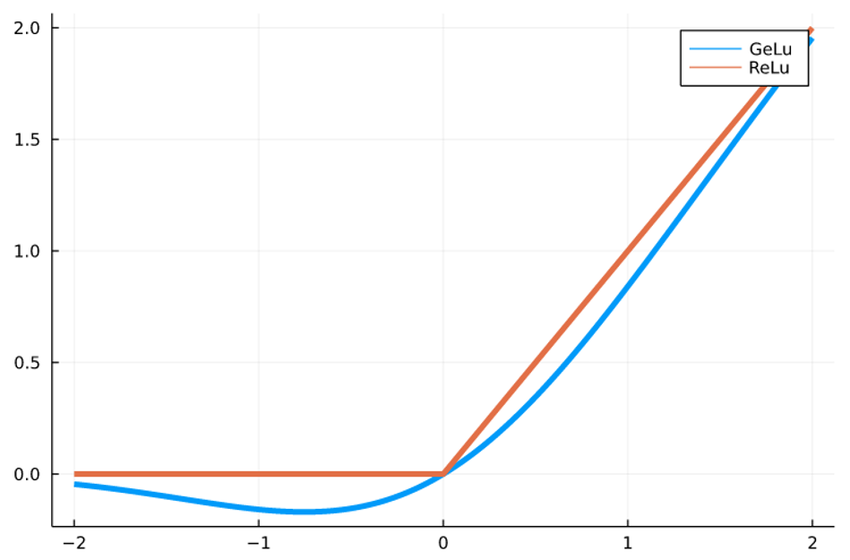

Just a quick side note. I don't know why but I've never seen people subclassing `nn.Sequential` to avoid writing the `forward` method. Start doing it, this is how object programming works!

**Finally**, we can create the Transformer Encoder Block
<img src="https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/TransformerBlock.png?raw=true" alt="drawing" width="200"/>


`ResidualAdd` allows us to define this block in an elegant way

In [35]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs): # kwargs: 추가 전달할 파라미터 - num_heads, dropout등
        super().__init__(
            
            # Residual Connection을 사용하여 <원래 입력 + Attention 결과>
            # 이렇게 MultiHeadAttention과 FeedForwardBlock을 쌓음
            
            # 입.출력: [1, 197, 768]
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size), # 입력 정규화.
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock( # MLP
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

Let's test it

In [36]:
# 테스트
patches_embedded = PatchEmbedding()(x) # [1, 197, 768]
TransformerEncoderBlock()(patches_embedded).shape # -> [1, 197, 768]

torch.Size([1, 197, 768])

you can also PyTorch build-in multi-head attention but it will expect 3 inputs: queries, keys, and values. You can subclass it and pass the same input

### Transformer

In ViT only the Encoder part of the original transformer is used. Easily, the encoder is `L` blocks of `TransformerBlock`.


In [37]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])
                

- depth: int = 12 (Encoder Block 개수)
    - 즉 depth만큼 TransformerEncoderBlock을 쌓음
    
- kwargs: MultiHeadAttention의 num_heads, dropout, FeedForwardBlock의 expansion 등

Easy peasy!

## Head

The last layer is a normal fully connect that gives the class probability. It first performs a basic mean over the whole sequence.

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/ClassificationHead.png?raw=true)

In [38]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'), # [1, 197, 768] → [1, 768]
            # patch 개수로 평균냄: 모든 패치의 정보를 평균내어 하나의 벡터로.
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes)) # [1,768]->[1,1000]차원 (클래스 수)

- classification 수행
    - n_classes: 분류할 클래스 개수

## Vi(sual) T(rasnformer)

We can compose `PatchEmbedding`, `TransformerEncoder` and  `ClassificationHead` to create the final ViT architecture.

In [39]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        

We can use `torchsummary` to check the number of parameters

In [40]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19

et voilà

```
================================================================
Total params: 86,415,592
Trainable params: 86,415,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 364.33
Params size (MB): 329.65
Estimated Total Size (MB): 694.56
---------------------------------------------------------------
```

I checked the parameters with other implementations and they are the same!

# Conclusions

In this article, we have seen how to implement ViT in a nice, scalable, and customizable way. I hope it was useful.

By the way, I am working on a **new computer vision library called [glasses](https://github.com/FrancescoSaverioZuppichini/glasses), check it out if you like**

Take care :)

Francesco